<a href="https://colab.research.google.com/github/SergiySpv/ney_m22/blob/main/Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Лабораторна 6

з дисципоіни "Нейроні мережі"

студента групи кн-31

Сопова Сергія

Виконати вирішення задачі класифікації для 3 класів з набору даних food101 з використанням різних моделей нейронних мереж:

CNN модель; Resnet модель; Efficientnet модель (моделі 1.1-1.3 з використанням оптимізатора Adam) 1.4. (1.5) Моделі 1.2,1.3 з використанням оптимізатора SGD. 1.6. (1.7) Моделі 1.2,1.3 отримані за допомогою tf.keras.applications та треновані з використанням fine-tuning (останні 10 шарів)
Індекси класів визначити індивідуально за залежностями: i1=n-1,i2=n+29,i3=n+59 (де і1,і2,і3 - індекс класу (починаючи з 0) у відсортованому за алфавітом наборі даних, n - номер за списком групи.
Порівняти результати моделювання із використанням TensorBoard
Графік(и) порівняння результатів завантажити у форматі .svg та вставити у підсумковий файл поряд із та відповідними висновками

Набір данних

In [1]:
import zipfile

# Download zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("101_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-05-24 15:26:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 142.250.148.128, 108.177.112.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   191MB/s    in 9.2s    

2022-05-24 15:26:17 (169 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



Відбираємо класси

In [2]:
import pathlib
import numpy as np
import os

#Кількість зображень в файлі
data_dir_train = pathlib.Path("101_food_classes_10_percent/train/") 
data_dir_test = pathlib.Path("101_food_classes_10_percent/test/")
num_food_images_train = len(os.listdir(data_dir_train))
print('Count of images are in a file:', num_food_images_train)

#Відберемо 3 задані варіанти
arr_index = [7,37,67]
class_names = np.array(sorted([item.name for item in data_dir_train.glob('*')]))
new_class_names = [class_names[arr_index[0]], class_names[arr_index[1]],class_names[arr_index[2]]]
print('Our classes:', new_class_names)

Count of images are in a file: 101
Our classes: ['bibimbap', 'filet_mignon', 'omelette']


Видалемо не наші класи

In [3]:
from pathlib import Path
import shutil

#Видалимо всі класи, окрім заданих
for name in class_names:
  if name != new_class_names[0] and name != new_class_names[1] and name != new_class_names[2]:
    dirpath = Path(data_dir_train) / name
    dirpath_test = Path(data_dir_test) / name
    if dirpath_test.exists() and dirpath_test.is_dir():
        shutil.rmtree(dirpath)
        shutil.rmtree(dirpath_test)
print('Test:', os.listdir(data_dir_test))
print('Train:', os.listdir(data_dir_train))

Test: ['filet_mignon', 'omelette', 'bibimbap']
Train: ['filet_mignon', 'omelette', 'bibimbap']


Вивід

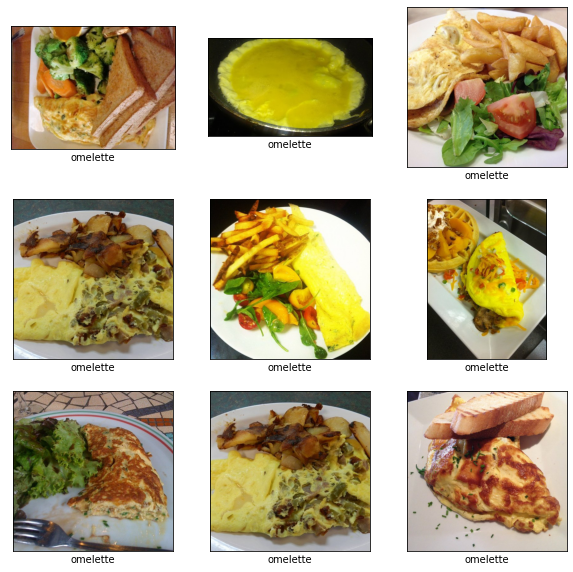

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    target_folder = '101_food_classes_10_percent/train/'+'omelette'
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.xlabel('omelette')
plt.show()

Нормування та перетворення файлів в дані

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "101_food_classes_10_percent/test/"
test_dir = "101_food_classes_10_percent/train/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical')

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 750 images belonging to 3 classes.
Found 225 images belonging to 3 classes.


Підготовка

In [8]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')

Found 750 images belonging to 3 classes.


CNN

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.callbacks import TensorBoard

model = Sequential([
  Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(3, activation='softmax')
])

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

tensorboard = TensorBoard(log_dir='logs/cnn', histogram_freq=1)

history_model = model.fit(train_data_augmented,
                          epochs=10,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[tensorboard])

Epoch 1/10
24/24 [==============================] - 60s 2s/step - loss: 1.3555 - accuracy: 0.4280 - val_loss: 0.9117 - val_accuracy: 0.6489
Epoch 2/10
24/24 [==============================] - 52s 2s/step - loss: 0.8691 - accuracy: 0.6027 - val_loss: 0.7945 - val_accuracy: 0.6844
Epoch 3/10
24/24 [==============================] - 53s 2s/step - loss: 0.8360 - accuracy: 0.6293 - val_loss: 0.8930 - val_accuracy: 0.6400
Epoch 4/10
24/24 [==============================] - 51s 2s/step - loss: 0.7888 - accuracy: 0.6627 - val_loss: 0.9921 - val_accuracy: 0.6578
Epoch 5/10
24/24 [==============================] - 51s 2s/step - loss: 0.7482 - accuracy: 0.6880 - val_loss: 0.8245 - val_accuracy: 0.7067
Epoch 6/10
24/24 [==============================] - 49s 2s/step - loss: 0.6895 - accuracy: 0.7240 - val_loss: 0.7674 - val_accuracy: 0.7111
Epoch 7/10
24/24 [==============================] - 49s 2s/step - loss: 0.7043 - accuracy: 0.7147 - val_loss: 0.7370 - val_accuracy: 0.7156
Epoch 8/10
24/24 [==

Resnet(Adam)

In [10]:
import tensorflow_hub as hub

model_2 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_101/feature_vector/5",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(3, activation='softmax')
])
model_2.build([None, 224, 224, 3])  # Batch input shape.

model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

tensorboard_2 = TensorBoard(log_dir='logs/resnet(adam)', histogram_freq=1,
                          write_graph=True, write_images=False)

history_model_2 = model_2.fit(train_data_augmented,
                          epochs=10,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[tensorboard_2])

Epoch 1/10
24/24 [==============================] - 294s 12s/step - loss: 0.7667 - accuracy: 0.6653 - val_loss: 0.4914 - val_accuracy: 0.7911
Epoch 2/10
24/24 [==============================] - 286s 12s/step - loss: 0.3306 - accuracy: 0.8693 - val_loss: 0.4107 - val_accuracy: 0.8667
Epoch 3/10
24/24 [==============================] - 260s 11s/step - loss: 0.2677 - accuracy: 0.8973 - val_loss: 0.3889 - val_accuracy: 0.8578
Epoch 4/10
24/24 [==============================] - 261s 11s/step - loss: 0.2121 - accuracy: 0.9227 - val_loss: 0.3703 - val_accuracy: 0.8578
Epoch 5/10
24/24 [==============================] - 261s 11s/step - loss: 0.2188 - accuracy: 0.9240 - val_loss: 0.4136 - val_accuracy: 0.8533
Epoch 6/10
24/24 [==============================] - 286s 12s/step - loss: 0.1732 - accuracy: 0.9347 - val_loss: 0.3590 - val_accuracy: 0.8667
Epoch 7/10
24/24 [==============================] - 286s 12s/step - loss: 0.1587 - accuracy: 0.9427 - val_loss: 0.3543 - val_accuracy: 0.8667
Epoch 

EfficientNet(Adam)

In [11]:
import tensorflow_hub as hub

model_3 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(3, activation='softmax')
])
model_3.build([None, 224, 224, 3])  # Batch input shape.

model_3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

tensorboard_3 = TensorBoard(log_dir='logs/efficientnet(adam)', histogram_freq=1,
                          write_graph=True, write_images=False)

history_model_3 = model_3.fit(train_data_augmented,
                          epochs=10,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[tensorboard_3])

Epoch 1/10
24/24 [==============================] - 77s 3s/step - loss: 0.8229 - accuracy: 0.6667 - val_loss: 0.5156 - val_accuracy: 0.8756
Epoch 2/10
24/24 [==============================] - 55s 2s/step - loss: 0.3869 - accuracy: 0.9120 - val_loss: 0.3489 - val_accuracy: 0.8978
Epoch 3/10
24/24 [==============================] - 64s 3s/step - loss: 0.2722 - accuracy: 0.9280 - val_loss: 0.2901 - val_accuracy: 0.9111
Epoch 4/10
24/24 [==============================] - 65s 3s/step - loss: 0.2311 - accuracy: 0.9387 - val_loss: 0.2593 - val_accuracy: 0.9244
Epoch 5/10
24/24 [==============================] - 55s 2s/step - loss: 0.1923 - accuracy: 0.9467 - val_loss: 0.2374 - val_accuracy: 0.9244
Epoch 6/10
24/24 [==============================] - 65s 3s/step - loss: 0.1773 - accuracy: 0.9533 - val_loss: 0.2232 - val_accuracy: 0.9244
Epoch 7/10
24/24 [==============================] - 55s 2s/step - loss: 0.1567 - accuracy: 0.9640 - val_loss: 0.2139 - val_accuracy: 0.9244
Epoch 8/10
24/24 [==

Resnet(SGD)

In [ ]:
model_4 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_101/feature_vector/5",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(3, activation='softmax')
])
model_4.build([None, 224, 224, 3])  # Batch input shape.

model_4.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])

tensorboard_4 = TensorBoard(log_dir='logs/resnet(sgd)', histogram_freq=1,
                          write_graph=True, write_images=False)

history_model_4 = model_4.fit(train_data_augmented,
                          epochs=10,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[tensorboard_4])

Epoch 1/10
24/24 [==============================] - 266s 11s/step - loss: 0.6935 - accuracy: 0.7147 - val_loss: 0.4669 - val_accuracy: 0.8533
Epoch 2/10
24/24 [==============================] - 258s 11s/step - loss: 0.3497 - accuracy: 0.8547 - val_loss: 0.4206 - val_accuracy: 0.8756
Epoch 3/10
24/24 [==============================] - 283s 12s/step - loss: 0.2669 - accuracy: 0.8987 - val_loss: 0.3763 - val_accuracy: 0.8667
Epoch 4/10
24/24 [==============================] - 259s 11s/step - loss: 0.2654 - accuracy: 0.9080 - val_loss: 0.3744 - val_accuracy: 0.8756
Epoch 5/10
24/24 [==============================] - 285s 12s/step - loss: 0.2251 - accuracy: 0.9080 - val_loss: 0.3837 - val_accuracy: 0.8844
Epoch 6/10
24/24 [==============================] - 284s 12s/step - loss: 0.2014 - accuracy: 0.9240 - val_loss: 0.3391 - val_accuracy: 0.8889
Epoch 7/10
24/24 [==============================] - 285s 12s/step - loss: 0.2059 - accuracy: 0.9187 - val_loss: 0.3274 - val_accuracy: 0.8800
Epoch 

EfficientNet(SGD)

In [ ]:
model_5 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(3, activation='softmax')
])
model_5.build([None, 224, 224, 3])  # Batch input shape.

model_5.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

tensorboard_5 = TensorBoard(log_dir='logs/efficientnet(sgd)', histogram_freq=1,
                          write_graph=True, write_images=False)

history_model_5 = model_5.fit(train_data_augmented,
                          epochs=10,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[tensorboard_5])

Resnet(SGD) Fine-training

In [ ]:
resnet_model = tf.keras.applications.resnet.ResNet101(classes=3, weights=None)
for layer in resnet_model.layers:
  layer.trainable = False;

for layer in resnet_model.layers[-10:]:
  layer.trainable = True;

tensorboard_6 = tf.keras.callbacks.TensorBoard(log_dir='logs/resnet(sgd)tunnig', histogram_freq=1,
                                               write_graph=True, write_images=False)

resnet_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])

history_model_6 = resnet_model.fit(train_data_augmented,
                          epochs=10,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[tensorboard_6])

EfficientNet(SGD) Fine-training

In [ ]:
eff_model = tf.keras.applications.efficientnet.EfficientNetB0(classes=3, weights=None)
for layer in eff_model.layers:
  layer.trainable = False;

for layer in eff_model.layers[-10:]:
  layer.trainable = True;

tensorboard_7 = tf.keras.callbacks.TensorBoard(log_dir='logs/efficientnet(sgd)tunnig', histogram_freq=1,
                                               write_graph=True, write_images=False)

eff_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])

history_model_7 = eff_model.fit(train_data_augmented,
                          epochs=10,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[tensorboard_7])